In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint
from scipy.interpolate import UnivariateSpline

In [40]:
# function definitions

# second differential using finite differnces
def diffTwo(Z):
    # first order, maybe try higher order
    Zcenter = Z[1:-1]
    Zleft = Z[:-2]
    Zright = Z[2:]
    return (Zleft - 2*Zcenter + Zright) / dx**2

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def discretisation(size, T, increments=101):
    x = np.linspace(0, size, increments)
    dx = x[1] - x[0]
    t = np.linspace(0, T*3600, increments)
    return x, dx, t

# right hand side of simple diffusion equation
def diffusion(u, t, Du):
    dudt = np.zeros_like(u)
    dudt[1:-1] = Du * diffTwo(u)
    # Neumann conditions:
    dudt[0] = 0
    dudt[-1] = 0
    return dudt

# right hand side of 2 component reaction diffusion system
def reactiondiffusion(y, t, Da, delta_a, n, Ka, alpha_g, delta_g):
    varLength = int(len(y)/2)
    a = y[0:varLength]
    g = y[varLength:]
    ac = a[1:-1]
    gc = g[1:-1]
    dydt = np.zeros_like(y)
    dydt[1:varLength-1] = Da*diffTwo(a) - delta_a*ac
    dydt[varLength+1:-1] = (alpha_g*np.power(ac,n))/(np.power(Ka,n)+np.power(ac,n)) - delta_g*gc
    # da/dt, dg/dt equal zero at boundary (Neumann condition)
    return dydt

# right hand side of 2 component reaction diffusion system
def reactiondiffusion2(y, t, rho, delta_c, K, n, D_c, alpha, delta_a, D_a):
    varLength = int(len(y)/2)
    c = y[0:varLength]
    a = y[varLength:]
    cc = c[1:-1]
    ac = a[1:-1]
    dydt = np.zeros_like(y)
    dydt[1:varLength-1] = rho - delta_c*cc*hill(ac,K,n) + D_c*diffTwo(c)
    dydt[varLength+1:-1] = alpha*cc - delta_a*ac + D_a*diffTwo(a)
    # da/dt, dg/dt equal zero at boundary (Neumann condition)
    return dydt

# returns the full width at half maximum of the front
def frontWidth(g, maxX=50):
    maxTime = np.argmax(g[:,maxX])
    maxValue = g[maxTime,maxX]
    #cond = g>0.5*maxValue
    #return (cond[maxTime,:]==True).sum()
    spline = UnivariateSpline(x[:-1], (g[maxTime,:]-0.5*maxValue), s=0)
    r1, r2 = spline.roots()
    return r2 - r1


# returns the time at which half maximum g is reached
def halfMaxTime(g, maxX=50):
    maxValue = np.max(g[:,maxX])
    cond = g<0.5*maxValue
    return (cond[:,maxX]==True).sum()

# hill function
def hill(x,K,n):
    return np.power(x,n)/(np.power(K,n)+np.power(x,n))


Differential equation: 2 component reaction diffusion system
$$ \frac{\partial c}{\partial t} = \rho - \delta_c c \Phi(a) + D_c \frac{\partial^2 c}{\partial x^2} $$
$$ \frac{\partial a}{\partial t} = \alpha c - \delta_a a + D_a \frac{\partial^2 a}{\partial x^2} $$
c is the cell density, a is the concentration of AHL.
$$ \Phi(a) = \frac{a^n}{K^n + a^n} $$

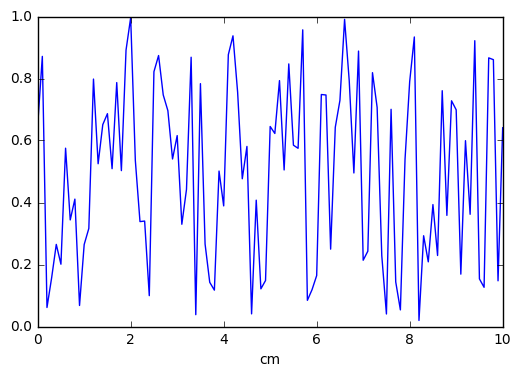

In [47]:
# Initial Conditions

c0 = np.random.rand(len(x))
a0 = np.zeros_like(c0)

y0 = np.append(c0,a0)

plt.plot(x*100,c0)
plt.xlabel('cm');

In [97]:
# Parameters

size = 0.1   # meters
T = 30   # hours
x, dx, t = discretisation(size, T, 101)

rho = 1e-4
delta_c = 1.1e-4
K = 1
n = 1.8
D_c = 1e-12
alpha = 0.05
delta_a = 1e-4
D_a = 1e-6

In [98]:
# Run

y = odeint(reactiondiffusion2, y0, t, (rho, delta_c, K, n, D_c, alpha, delta_a, D_a))
varLength = int(len(y[0,:])/2)
c = y[:,0:varLength-1]
a = y[:,varLength:-1]

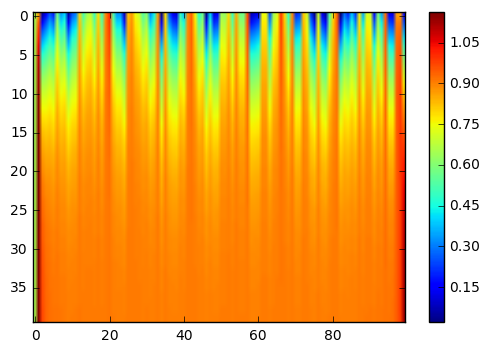

In [106]:
plt.imshow(c[0:40,:], aspect='auto')
plt.colorbar()

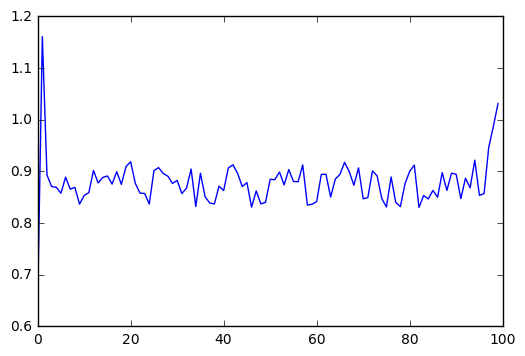

In [102]:
plt.plot(c[20,:])